In [5]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm
from itertools import product
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import precision_recall_curve, ndcg_score, average_precision_score

In [6]:
import warnings
warnings.filterwarnings('ignore')

In [7]:
pd.set_option('display.max_columns', None)  # or 1000

In [8]:
data = pd.read_csv("data.csv")
origin_matches = data[data["is_origin_pnp"] == 1].copy()
data = data[data["is_origin_pnp"] != 1].copy()

# убираем модификации с нулевой массой
data = data[abs(data["mod_mass_shift"]) > 0.1]
data = data[abs(data["mod_mass_shift"]) < 300.0]

# переводим pvalue в логарифмическую шкалу
data["pvalue"] = np.log(data["pvalue"])
data["notblind_pvalue"] = np.log(data["notblind_pvalue"])
data.rename(columns={"pvalue": "log_pvalue", "notblind_pvalue": "notblind_log_pvalue"}, inplace=True)

# data 

In [9]:
keys2drop = ["notblind_score", "notblind_log_pvalue", "nps_score", "nps_mod_position", "nps_mod_node", 
             "nps_mod_mass_shift", "nps_in_deg", "nps_out_deg", "nps_deg", "nps_correctness", "in_deg", 
             "out_deg", "component", "is_cluster_correct", 
            ]

data.drop(columns = keys2drop, inplace=True)
data

,scan,parent_mass,ind,mass,num_aa,formula,structure,score,log_pvalue,mod_position,mod_node,mod_mass_shift,deg,is_origin_pnp,correctness,mod_mass_freq
0,7,661.386724,"(0, 376)",703.431,5,C40H57N5O6,linear,6.0,-30.010078,0,"('C12H19O', 179.144)",-42.04420,1,0,correctly found replacement,0.030516
1,7,661.386724,"(0, 3239)",721.441,5,C40H59N5O7,linear,6.0,-30.010078,0,"('C12H21O2', 197.154)",-60.05470,1,0,correctly found replacement,0.004602
3,65,606.402724,"(0, 511)",620.415,4,C33H56N4O7,cyclic,7.0,-34.502724,0,"('C21H40O2', 324.303)",-14.01220,2,0,correctly found replacement,0.252240
4,65,606.402724,"(0, 1300)",494.274,4,C24H38N4O7,cyclic,7.0,-34.502724,0,"('C12H22O2', 198.162)",112.12900,2,0,correctly found replacement,0.002422
7,77,595.307724,"(0, 94)",609.327,5,C31H43N7O6,linear,5.0,-28.425074,0,"('C6H11NO', 113.084)",-14.01980,2,0,correctly found replacement,0.252240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17948,11680,703.432724,"(0, 3239)",721.441,5,C40H59N5O7,linear,6.0,-32.718716,0,"('C12H21O2', 197.154)",-18.00870,1,0,correctly found replacement,0.017801
17950,11836,1036.482724,"(0, 523)",1022.470,8,C53H66N8O13,branch-cyclic,12.0,-56.714229,7,"('C3H4NO2', 86.0242)",14.00780,3,0,correctly found replacement,0.252240
17951,11836,1036.482724,"(0, 992)",1038.510,8,C54H70N8O13,branch-cyclic,12.0,-56.714229,4,"('C10H11NO2', 177.079)",-2.02351,2,0,correctly found replacement,0.039840
17954,11836,1036.482724,"(0, 1788)",1198.550,8,C54H78N12O19,cyclic,9.0,-37.951198,3,"('C9H9NO3', 179.058)",-162.06800,2,0,incorrect (6 -> 6),0.006902


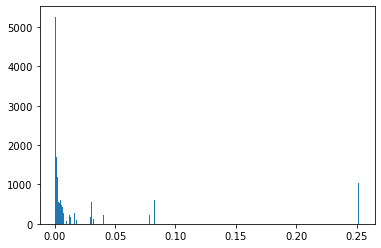

In [10]:
plt.hist(data["mod_mass_freq"], bins=300)
plt.show()

In [11]:
keys2viz = ["mass", "num_aa", "score", "logpvalue", "mod_node", "mod_mass_shift", "deg", "mod_mass_freq"]

# print(data.loc[data["scan"] == 487, keys2viz].to_latex(index=False))

### Определяем истинные метки

In [12]:
data[~data["correctness"].str.startswith("incorrect")]["correctness"].value_counts()

correctly found replacement                          1058
correctly found replacement, but neighbour marked     328
correctly found insertion                              58
correctly found deletion                               16
insertion of a large number of AA (3)                  12
Name: correctness, dtype: int64

In [13]:
data[data["correctness"].str.startswith("incorrect")]["correctness"].value_counts()

incorrect (2 -> 2)      1596
incorrect (3 -> 3)      1533
incorrect (4 -> 4)      1164
incorrect (5 -> 5)       575
incorrect (4 -> 3)       469
                        ... 
incorrect (11 -> 10)       1
incorrect (11 -> 14)       1
incorrect (9 -> 14)        1
incorrect (12 -> 7)        1
incorrect (1 -> 5)         1
Name: correctness, Length: 92, dtype: int64

In [14]:
data[(data["correctness"].str.startswith("incorrect (1 ")) | 
     (data["correctness"].str.startswith("incorrect (2 ")) | 
     (data["correctness"].str.endswith(" 1)")) | 
     (data["correctness"].str.endswith(" 2)"))
    ]["correctness"].value_counts()

incorrect (2 -> 2)    1596
incorrect (2 -> 3)     375
incorrect (3 -> 2)     324
incorrect (2 -> 4)     252
incorrect (1 -> 2)     197
incorrect (4 -> 2)     159
incorrect (1 -> 3)     150
incorrect (2 -> 1)     131
incorrect (2 -> 5)     114
incorrect (1 -> 4)      36
incorrect (3 -> 1)      21
incorrect (2 -> 6)      14
incorrect (5 -> 2)       3
incorrect (1 -> 6)       2
incorrect (1 -> 5)       1
Name: correctness, dtype: int64

In [15]:
appropriate_correctness = ["correctly found replacement", 
                           "correctly found replacement, but neighbour marked", 
                           "correctly found insertion", 
                           "correctly found deletion", 
                           "incorrect (2 -> 2)", 
                          ]

def correctness2binary(correctness: str):
    return int(correctness in appropriate_correctness)

data["binary_true"] = data["correctness"].apply(correctness2binary)

### Убираем сканы, где все матчи только (не)правильные

In [16]:
data["scan"].unique().shape

(349,)

In [17]:
appropriate_scans = []

for scan in data["scan"].unique():
    labels = data[data["scan"] == scan]["binary_true"]
    if 0 < sum(labels) < len(labels):
        appropriate_scans.append(scan)

appropriate_scans = np.array(appropriate_scans)
appropriate_scans.shape

(292,)

In [18]:
# scans = data["scan"].unique()
scans = appropriate_scans.copy()
n_scans = scans.shape[0]

rng = np.random.default_rng(17)
rng.shuffle(scans)

train_scans = scans[:int(0.8 * n_scans)]
test_scans = scans[int(0.8 * n_scans):]
train_scans.sort()
test_scans.sort()

In [20]:
feature_columns = ["scan", "mass", "num_aa", "formula", "structure", "score", "log_pvalue", "mod_node", 
                   "mod_mass_shift", "deg", "mod_mass_freq", "binary_true", 
                  ]

df_train = data.loc[data["scan"].isin(train_scans), feature_columns].copy()
df_test = data.loc[data["scan"].isin(test_scans), feature_columns].copy()

df_train.shape, df_test.shape

((11348, 12), (3171, 12))

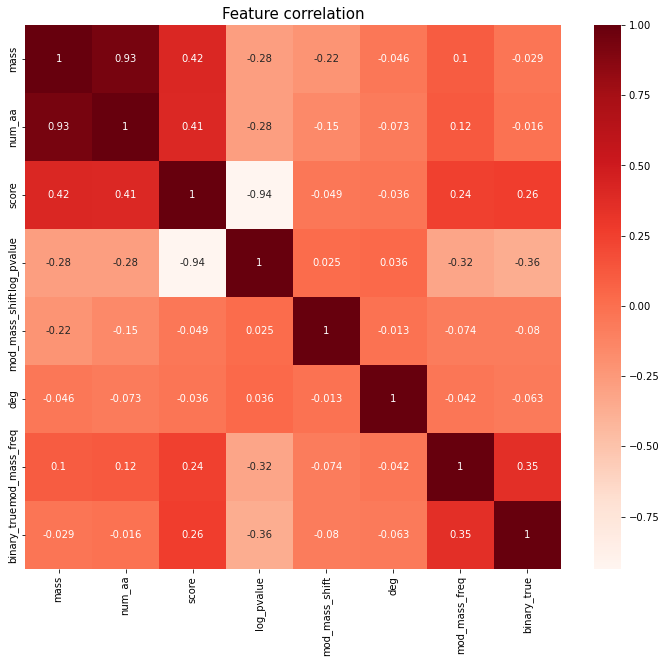

In [21]:
plt.figure(figsize=(12, 10))
plt.title("Feature correlation", fontsize=15)
cor = df_train.drop(columns=["scan"]).corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.savefig("FeatureCor.png")
plt.show()

In [ ]:
feature_columns = ["scan", "formula", "structure", "notblind_pvalue", "pvalue", "mod_node", "mod_mass_shift", 
                   "mod_mass_freq", "binary_true"]

df_train = data.loc[data["scan"].isin(train_scans), feature_columns].copy()
df_test = data.loc[data["scan"].isin(test_scans), feature_columns].copy()

df_train.shape, df_test.shape

## Метрики качества

In [ ]:
# def roc_auc(y_pred, scan, top_k=10000):
#     df = pd.concat([pd.DataFrame(y_pred, columns=["y_pred"]), 
#                     data[data["scan"] == scan][["pvalue", "binary_true"]].reset_index(drop=True)
#                    ], axis=1).sort_values(["y_pred", "pvalue"], ascending=False)[:top_k]
    
#     n_ones = np.array(df.groupby(["y_pred", "pvalue"], sort=True).sum())
#     n_zeros = np.array(df.groupby(["y_pred", "pvalue"], sort=True).count()) - n_ones
    
#     if sum(n_zeros) == 0:
#         return 1.0
#     elif sum(n_ones) == 0:
#         return 0.0
    
#     n_ones = np.insert(np.cumsum(n_ones), 0, 0)
#     n_ones = n_ones / n_ones[-1]
#     n_zeros = np.insert(np.cumsum(n_zeros), 0, 0)
#     n_zeros = n_zeros / n_zeros[-1]
    
#     return 0.5 * np.dot(n_ones[1:] - n_ones[:-1], n_zeros[1:] + n_zeros[:-1])


# def mean_roc_auc(y_preds, scans, top_k=10000):
#     lens = [len(data[data["scan"] == scan]) for scan in scans]
#     split_indices = np.cumsum(lens)
#     scores = np.array([roc_auc(y_pred, scan, top_k) for y_pred, scan in 
#                        zip(np.split(y_preds, split_indices[:-1]), scans)])
    
#     return np.mean(scores), np.std(scores)


def mean_average_precision(y_preds, scans, top_k=10000):
    lens = [len(data[data["scan"] == scan]) for scan in scans]
    split_indices = np.cumsum(lens)
    scores = np.array([average_precision_score(np.array(data.loc[data["scan"] == scan, "binary_true"]), y_pred) 
                       for y_pred, scan in zip(np.split(y_preds, split_indices[:-1]), scans)])
    
    return np.mean(scores), np.std(scores)


def mean_ndcg(y_preds, scans, top_k=10000):
    lens = [len(data[data["scan"] == scan]) for scan in scans]
    split_indices = np.cumsum(lens)
    scores = np.array([ndcg_score(np.array(data.loc[data["scan"] == scan, "binary_true"]).reshape(1, -1), 
                                  y_pred.reshape(1, -1), k=top_k) 
                       for y_pred, scan in zip(np.split(y_preds, split_indices[:-1]), scans)])
    
    return np.mean(scores), np.std(scores)

### Посмотрим, как обстоят дела до обучения

In [ ]:
# print(mean_roc_auc(np.array(df_test["pvalue"]), test_scans))
# print(mean_roc_auc(np.array(df_test["pvalue"]), test_scans, top_k=5))
print("MAP    = %0.3f (+/- %0.3f)" % mean_average_precision(np.array(df_test["pvalue"]), test_scans))
print("NDCG   = %0.3f (+/- %0.3f)" % mean_ndcg(np.array(df_test["pvalue"]), test_scans))
print("NDCG@1 = %0.3f (+/- %0.3f)" % mean_ndcg(np.array(df_test["pvalue"]), test_scans, top_k=1))
print("NDCG@5 = %0.3f (+/- %0.3f)" % mean_ndcg(np.array(df_test["pvalue"]), test_scans, top_k=5))

У нас будут разные модели

In [ ]:
models = {}
param_grids = {}
best_estimators = {}
best_params = {}

# Binary Classifiers

## Features Preparing

In [ ]:
df_train

In [ ]:
df_train.describe()

In [ ]:
# ori_matches = origin_matches[origin_matches["scan"].isin(train_scans)]
# ori_matches

In [ ]:
# plt.figure(figsize=(10, 10))

# plt.hist2d(ori_matches["num_aa"], ori_matches["mass"], bins=50)
# # plt.scatter(ori_matches["num_aa"], ori_matches["score"])
# plt.show()

In [ ]:
# plt.figure(figsize=(10, 10))

# plt.hist2d(ori_matches["num_aa"], ori_matches["score"], bins=50)
# # plt.scatter(ori_matches["num_aa"], ori_matches["score"])
# plt.show()

In [ ]:
# ori_matches[ori_matches["score"] / ori_matches["num_aa"] < 0.5]

In [ ]:
# df1 = df_train[df_train["binary_true"] == 1].copy()
# df0 = df_train[df_train["binary_true"] == 0].copy()

# plt.figure(figsize=(40, 30))
# plt.scatter(df1["mod_mass_shift"], df1["pvalue"], c='r', marker='.')
# plt.scatter(df0["mod_mass_shift"], df0["pvalue"], c='b', marker='.')
# plt.show()

In [ ]:
df_train

In [ ]:
def features_preparing(df: pd.DataFrame, means=None, stds=None, normalize=False):
    X = df[["mod_mass_shift", "mod_mass_freq"]].copy()
    X["mod_mass_shift"] = np.abs(X["mod_mass_shift"])
    X["mod_mass_fraction"] = X["mod_mass_shift"].apply(lambda x: 0.5 - abs(x - np.floor(x) - 0.5))
    X["log_pvalue"] = df["pvalue"]
    X["pvalue_changing"] = df["pvalue"] - df["notblind_pvalue"]
    
    if normalize:
        X.drop(columns=["mod_mass_shift"], inplace=True)
        if means is None or stds is None:
            means = X.mean()
            stds = X.std()
        X = (X - means) / stds
    
    y = df["binary_true"].copy()
    
    return X, y, means, stds

In [ ]:
X_train, y_train, *_ = features_preparing(df_train)
X_test, y_test, *_ = features_preparing(df_test)
X_train_normalized, _, means, stds = features_preparing(df_train, normalize=True)
X_test_normalized, *_ = features_preparing(df_test, means=means, stds=stds, normalize=True)


X_train

In [ ]:
X_train_normalized

In [ ]:
X_train_normalized.describe()

In [ ]:
def kfold_cross_validation(classifier, param_grid, scoring, X_train, y_train, n_splits=5):
    kf = KFold(n_splits=n_splits)

    best_score = 0

    for p in product(*param_grid.values()):
        param = {k: v for k, v in zip(param_grid.keys(), p)}
        val_scores = []
        val_stds = []
        for train_index, val_index in kf.split(train_scans):
            clf = classifier(random_state=17, **param)
            if classifier == LogisticRegression:
                clf.tol = 1e-6
                clf.solver = "liblinear"
                clf.max_iter = 1000
            
            ind1 = data[data["scan"].isin(train_scans[train_index])].index
            ind2 = data[data["scan"].isin(train_scans[val_index])].index
            clf.fit(X_train.loc[ind1], y_train[ind1])
            
            if classifier == LogisticRegression:
                y_pred = clf.predict_proba(X_train.loc[ind2])[:, 1]
            else:
                y_pred = clf.predict(X_train.loc[ind2])
            
            mean, std = scoring(y_pred, np.sort(train_scans[val_index]))
            val_scores.append(mean)
            val_stds.append(std)
        
        val_scores = np.array(val_scores)
        val_stds = np.array(val_stds)
        
        if val_scores.mean() > best_score:
            best_score = val_scores.mean()
            best_param = param
        print("%0.4f (+/-%0.4f) for %r" % (val_scores.mean(), np.square((val_stds ** 2).sum()), param))

    print("Best result for: ", best_param)
    
    return best_param

def score_on_test(model_name, scoring, X_test, top_k=10000):
    if model_name == "logreg":
        y_pred = best_estimators[model_name].predict_proba(X_test)[:, 1]
    else:
        y_pred = best_estimators[model_name].predict(X_test)
    
    return scoring(y_pred, np.sort(test_scans), top_k=top_k)

## DecisionTreeClassifier

In [ ]:
model_name = "decision_tree"
scoring = mean_ndcg
# scoring = mean_average_precision

In [ ]:
models[model_name] = DecisionTreeClassifier

param_grids[model_name] = {
    "max_depth": [3, 5, 7, 10], 
    "criterion": ["gini", "entropy"], 
    "min_samples_leaf": [1, 2, 3, 5, 10], 
}

best_params[model_name] = kfold_cross_validation(models[model_name], param_grids[model_name], 
                                                 scoring, X_train, y_train)
best_estimators[model_name] = models[model_name](random_state=17, **best_params[model_name])
best_estimators[model_name].fit(X_train, y_train)

In [ ]:
score_on_test(model_name, scoring, X_test)

In [ ]:
from dtreeviz.trees import dtreeviz

# param_for_viz = {"max_depth": 5, "criterion": "gini", "min_samples_leaf": 10}
param_for_viz = best_params["decision_tree"]
estimator_for_viz = models["decision_tree"](random_state=17, **param_for_viz)
estimator_for_viz.fit(X_train, y_train)

viz = dtreeviz(estimator_for_viz, X_train, y_train,
               target_name="binary_true",
               feature_names=X_train.columns,
               class_names=[0, 1])

viz

## LogisticRegression

In [ ]:
model_name = "logreg"
scoring = mean_ndcg
# scoring = mean_average_precision

In [ ]:
models[model_name] = LogisticRegression

param_grids[model_name] = {
    "penalty": ["l1", "l2"], 
    "C": [0.0001, 0.0002, 0.0005, 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5, 1.0, 2.0, 5.0, 10.0], 
}

best_params[model_name] = kfold_cross_validation(models[model_name], param_grids[model_name], 
                                                 scoring, X_train_normalized, y_train)
best_estimators[model_name] = models[model_name](random_state=17, tol = 1e-6, solver = "liblinear", 
                                                 max_iter = 1000, **best_params[model_name])
best_estimators[model_name].fit(X_train_normalized, y_train)

In [ ]:
print(scoring(np.array(df_test["pvalue"]), test_scans))
print(score_on_test(model_name, scoring, X_test_normalized))

In [ ]:
print(X_train_normalized.columns)
print(best_estimators[model_name].coef_)

# Посмотрим на результаты

In [ ]:
model_name = "logreg"
# model_name = "decision_tree"

if model_name == "logreg":
    y_preds = best_estimators[model_name].predict_proba(X_test_normalized)[:, 1]
else:
    y_preds = best_estimators[model_name].predict(X_test)

df_test["y_pred"] = y_preds

df_viz = df_test.copy()
# df_viz = data[["scan", "ind", "mass", "num_aa", "formula", "notblind_score", "notblind_pvalue", "score", "pvalue", 
#                "mod_node", "mod_mass_shift", "mod_mass_freq", "correctness", "binary_true", "y_pred"]].copy()

In [ ]:
test_scans

In [ ]:
scan = 97
cur_df = df_viz[df_viz["scan"] == scan]
y_true = np.array(cur_df["binary_true"])
y_pval = np.array(cur_df["pvalue"])
y_pred = np.array(cur_df["y_pred"])
new_pos = pd.Series({ind: pos for pos, ind in enumerate(cur_df.sort_values(["y_pred"], ascending=False).index)})
old_pos = pd.Series({ind: pos for pos, ind in enumerate(cur_df.sort_values(["pvalue"], ascending=False).index)})
cur_df["gained/lost"] = old_pos - new_pos
print("NDCG score before = %0.4f" % ndcg_score(y_true.reshape(1, -1), y_pval.reshape(1, -1)))
print("NDCG score after  = %0.4f" % ndcg_score(y_true.reshape(1, -1), y_pred.reshape(1, -1)))
print("AP score before = %0.4f" % average_precision_score(y_true, y_pval))
print("AP score after  = %0.4f" % average_precision_score(y_true, y_pred))
cur_df.sort_values(["y_pred"], ascending=False)#.head(10)

In [ ]:
# plt.figure(figsize=(10, 7))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curve")

for scan in test_scans:
    cur_df = df_viz[df_viz["scan"] == scan]
    if len(cur_df) > 20:
        continue
    y_true = np.array(cur_df["binary_true"])
    y_pval = np.array(cur_df["pvalue"])
    y_pred = np.array(cur_df["y_pred"])
    new_pos = pd.Series({ind: pos for pos, ind in enumerate(cur_df.sort_values(["y_pred"], ascending=False).index)})
    old_pos = pd.Series({ind: pos for pos, ind in enumerate(cur_df.sort_values(["pvalue"], ascending=False).index)})
    cur_df["gained/lost"] = old_pos - new_pos
    precision, recall, thresholds = precision_recall_curve(y_true, y_pval)
    plt.plot(recall, precision, color='blue', linewidth=0.5, drawstyle="steps-post")
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
    plt.plot(recall, precision, color='red', linewidth=0.5, drawstyle="steps-post")
    print("Scan =", scan)
    print("AP score before     = %0.3f" % average_precision_score(y_true, y_pval))
    print("AP score after      = %0.3f" % average_precision_score(y_true, y_pred))
    print("NDCG score before   = %0.3f" % ndcg_score(y_true.reshape(1, -1), y_pval.reshape(1, -1)))
    print("NDCG score after    = %0.3f" % ndcg_score(y_true.reshape(1, -1), y_pred.reshape(1, -1)))
    print("NDCG@1 score before = %0.3f" % ndcg_score(y_true.reshape(1, -1), y_pval.reshape(1, -1), k=1))
    print("NDCG@1 score after  = %0.3f" % ndcg_score(y_true.reshape(1, -1), y_pred.reshape(1, -1), k=1))
    print("NDCG@5 score before = %0.3f" % ndcg_score(y_true.reshape(1, -1), y_pval.reshape(1, -1), k=5))
    print("NDCG@5 score after  = %0.3f" % ndcg_score(y_true.reshape(1, -1), y_pred.reshape(1, -1), k=5))
    print(cur_df.sort_values(["y_pred"], ascending=False)[["pvalue", "mod_node", "mod_mass_shift", "mod_mass_freq", 
                                                           "binary_true", "y_pred", "gained/lost"
                                                          ]])
    plt.show()

In [ ]:
plt.figure(figsize=(10, 7))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall curves")

for scan in test_scans:
    cur_df = df_viz[df_viz["scan"] == scan]
    y_true = np.array(cur_df["binary_true"])
    y_pval = np.array(cur_df["pvalue"])
    y_pred = np.array(cur_df["y_pred"])
    precision, recall, thresholds = precision_recall_curve(y_true, y_pval)
    plt.plot(recall, precision, color='blue', linewidth=0.3, drawstyle="steps-post")
#     precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
#     plt.plot(recall, precision, color='red', linewidth=0.3, drawstyle="steps-post")
plt.show()

In [ ]:
def curve_interpolation(x_curve, y_curve):
    xs, ys = [], []
    cur_x, cur_y = 0.0, 1.0
    for x, y in zip(x_curve, y_curve):
        xs.append(cur_x)
        ys.append(cur_y)
        cur_y = y
        xs.append(cur_x)
        ys.append(cur_y)
        cur_x = x
    xs.append(cur_x)
    ys.append(cur_y)
    mean_x_axis = np.linspace(0.0, 1.0, num=101)
    y_interp = np.interp(mean_x_axis, xs, ys)
    return y_interp

In [ ]:
fs = 20
plt.figure(figsize=(16, 9))
mean_x_axis = np.linspace(0.0, 1.0, num=101)

scan = 266
cur_df = df_viz[df_viz["scan"] == scan]
y_true = np.array(cur_df["binary_true"])
y_pval = np.array(cur_df["pvalue"])
y_pred = np.array(cur_df["y_pred"])
precision, recall, thresholds = precision_recall_curve(y_true, y_pval)
xs, ys = [], []
cur_x, cur_y = 0.0, 1.0
for x, y in zip(recall[-2::-1], precision[-2::-1]):
    xs.append(cur_x)
    ys.append(cur_y)
    cur_y = y
    xs.append(cur_x)
    ys.append(cur_y)
    cur_x = x
xs.append(cur_x)
ys.append(cur_y)
# print(recall[::-1])
# print(precision[::-1])
# print(xs)
# print(ys)
plt.plot(recall, precision, color='blue', linewidth=0.5, drawstyle="steps-post")
# plt.plot(xs, ys, color='blue', linewidth=0.5)
ys_interp_before = np.interp(mean_x_axis, xs, ys)
# precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
# plt.plot(recall, precision, color='red', linewidth=0.5, drawstyle="steps-post")
# ys_interp_after = np.interp(mean_x_axis, recall[::-1], precision[::-1])
plt.plot(mean_x_axis, ys_interp_before, color='blue', linewidth=0.5)

In [ ]:
fs = 20
plt.figure(figsize=(16, 9))
mean_x_axis = np.linspace(0.0, 1.0, num=101)
ys_interp_before = []
ys_interp_after = []

for scan in test_scans:
    cur_df = df_viz[df_viz["scan"] == scan]
    y_true = np.array(cur_df["binary_true"])
    y_pval = np.array(cur_df["pvalue"])
    y_pred = np.array(cur_df["y_pred"])
    precision, recall, thresholds = precision_recall_curve(y_true, y_pval)
#     plt.plot(recall, precision, color='blue', linewidth=0.3, drawstyle="steps-post")
    ys_interp_before.append(curve_interpolation(recall[-2::-1], precision[-2::-1]))
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
#     plt.plot(recall, precision, color='red', linewidth=0.3, drawstyle="steps-post")
    ys_interp_after.append(curve_interpolation(recall[-2::-1], precision[-2::-1]))

mean_y_before = np.mean(ys_interp_before, axis=0)
mean_y_after = np.mean(ys_interp_after, axis=0)
MAP_before = mean_average_precision(df_test["pvalue"].values, np.sort(test_scans))
MAP_after = mean_average_precision(df_test["y_pred"].values, np.sort(test_scans))
print(MAP_before, MAP_after)

plt.xlabel("Recall", fontsize=fs)
plt.ylabel("Precision", fontsize=fs)
plt.title("Average Precision-Recall curves", fontsize=fs)
plt.xticks(np.arange(0.0, 2.0, 0.1), fontsize=fs//2)
plt.yticks(np.arange(0.0, 2.0, 0.02), fontsize=fs//2)
# plt.xlim(0.0, 1.0)
# plt.ylim(0.0, 1.0)
plt.plot(mean_x_axis, mean_y_before, color="blue", lw=2.0, 
         label="APR curve for standard ranking (by P-Value), MAP = %0.2f" % MAP_before[0])
plt.plot(mean_x_axis, mean_y_after, color="red", lw=2.0, 
         label="APR curve after re-ranking, MAP = %0.2f" % MAP_after[0])
plt.legend(fontsize=fs)
plt.savefig("APRcurves.png")
plt.show()

In [ ]:
fs = 20
plt.figure(figsize=(16, 16))
mean_x_axis = np.linspace(0.0, 1.0, num=101)
ys_interp_before = []
ys_interp_after = []

for scan in test_scans:
    cur_df = df_viz[df_viz["scan"] == scan]
    y_true = np.array(cur_df["binary_true"])
    y_pval = np.array(cur_df["pvalue"])
    y_pred = np.array(cur_df["y_pred"])
    precision, recall, thresholds = precision_recall_curve(y_true, y_pval)
#     plt.plot(recall, precision, color='blue', linewidth=0.3, drawstyle="steps-post")
    ys_interp_before.append(curve_interpolation(recall[-2::-1], precision[-2::-1]))
    precision, recall, thresholds = precision_recall_curve(y_true, y_pred)
#     plt.plot(recall, precision, color='red', linewidth=0.3, drawstyle="steps-post")
    ys_interp_after.append(curve_interpolation(recall[-2::-1], precision[-2::-1]))

mean_y_before = np.mean(ys_interp_before, axis=0)
mean_y_after = np.mean(ys_interp_after, axis=0)
MAP_before = mean_average_precision(df_test["pvalue"].values, np.sort(test_scans))
MAP_after = mean_average_precision(df_test["y_pred"].values, np.sort(test_scans))
print(MAP_before, MAP_after)

plt.xlabel("Recall", fontsize=fs)
plt.ylabel("Precision", fontsize=fs)
plt.title("Average Precision-Recall curves", fontsize=fs)
plt.xticks(np.arange(0.0, 2.0, 0.1), fontsize=fs//2)
plt.yticks(np.arange(0.0, 2.0, 0.05), fontsize=fs//2)
plt.xlim(0.0, 1.0)
plt.ylim(0.0, 1.0)
plt.plot(mean_x_axis, mean_y_before, color="blue", lw=2.0, 
         label="APR curve for standard ranking (by P-Value), MAP = %0.2f" % MAP_before[0])
plt.plot(mean_x_axis, mean_y_after, color="red", lw=2.0, 
         label="APR curve after re-ranking, MAP = %0.2f" % MAP_after[0])
plt.legend(fontsize=fs, loc=3)
plt.savefig("APRcurves(y0to1).png")
plt.show()

In [ ]:
i = []

for j in data.index:
    if abs(float(data.loc[j, "mod_node"].split()[1][:-1]) + data.loc[j, "mod_mass_shift"]) < 0.1:
        i.append(j)

data[data.index.isin(i)].tail(17)

In [ ]:
data[(data["correctness"].str.startswith("incorrect")) & (~data["correctness"].str.startswith("incorrect ("))]

In [ ]:
data.head(1)